In [383]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [320]:
df = pd.read_pickle('endowment2.pkl')

In [321]:
X = df.loc[:,[
    'admission_rate',
    'admission_yield',
    'tuition',
    'public',
    'enrollment',
    'grad_pct',
    'graduation_rate',
    'financialaid_rate',
    'par_mean',
    'k_mean',
    'age',
    'sat_75',
    'sat_math',
    'sat_reading'
]]

y = df.loc[:,'log_endowment']

In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=999)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=456)

In [362]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [380]:
r2_score(y_train,lm.predict(X_train))

0.7940421432242033

In [381]:
r2_score(y_test,lm.predict(X_test))

0.6989141628471391

In [365]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [366]:
alphavec = 10**np.linspace(-5,2,300)
lasso_model = LassoCV(alphas = alphavec, cv=4, fit_intercept=True)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000e-05, 1.05539e-05, ..., 9.47521e+01, 1.00000e+02]),
    copy_X=True, cv=4, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [367]:
lasso_model.alpha_

0.01611973357388157

In [368]:
sorted(list(zip(np.absolute(lasso_model.coef_),lasso_model.coef_,X_train.columns)))

[(0.0, -0.0, 'graduation_rate'),
 (0.0, 0.0, 'sat_reading'),
 (0.010826856268359346, 0.010826856268359346, 'sat_math'),
 (0.056961471528190484, 0.056961471528190484, 'admission_yield'),
 (0.06160688999201723, 0.06160688999201723, 'financialaid_rate'),
 (0.12279020146944541, -0.12279020146944541, 'enrollment'),
 (0.13136037868522174, 0.13136037868522174, 'k_mean'),
 (0.14710691210387858, -0.14710691210387858, 'admission_rate'),
 (0.1768636532410433, 0.1768636532410433, 'par_mean'),
 (0.180491514127084, -0.180491514127084, 'grad_pct'),
 (0.182914253520968, 0.182914253520968, 'age'),
 (0.27869861439282456, -0.27869861439282456, 'public'),
 (0.3470306486628283, 0.3470306486628283, 'tuition'),
 (0.6205586060998299, 0.6205586060998299, 'sat_75')]

In [369]:
lambdavec = 10**np.linspace(-2,2,100)
alphavec = np.linspace(.01,1,100)

param_grid = {'alpha':list(lambdavec),'l1_ratio':list(alphavec)}

In [370]:
clf = GridSearchCV(ElasticNet(alpha=10,l1_ratio=.5), param_grid, cv=10, scoring='r2',iid=False)
clf.fit(X_tr,y_train)
best_elastic = clf.best_estimator_

In [371]:
np.sqrt(np.sum((best_elastic.predict(X_te) - y_test) **2))

6.513275756451422

Out of Sample R^2 and MSE

In [385]:
print(r2_score(y_test, best_elastic.predict(X_te)))
print(mean_squared_error(y_test, best_elastic.predict(X_te)))

0.715791278175093
0.5656368143943712


In sample R^2 and MSE

In [386]:
print(r2_score(y_train, best_elastic.predict(X_tr)))
print(mean_squared_error(y_train, best_elastic.predict(X_tr)))

0.7902876174345248
0.5633244568131728


In [374]:
sorted(list(zip(np.absolute(best_elastic.coef_),
                X_train.columns,
                best_elastic.coef_,
                np.round(best_elastic.coef_/std.scale_,10))))

[(0.021596208215971725, 'sat_reading', 0.021596208215971725, 3.2941101783),
 (0.023613472980724817, 'sat_math', 0.023613472980724817, 3.0907401013),
 (0.06420917598002433, 'graduation_rate', 0.06420917598002433, 0.0033394444),
 (0.06522520142691239, 'admission_yield', 0.06522520142691239, 0.0049949014),
 (0.08280489630410895, 'financialaid_rate', 0.08280489630410895, 0.0060914692),
 (0.12805581930547472, 'enrollment', -0.12805581930547472, -1.32484e-05),
 (0.15342819029054613, 'k_mean', 0.15342819029054613, 1.03233e-05),
 (0.17647921307423878, 'admission_rate', -0.17647921307423878, -0.0084119334),
 (0.177454632494272, 'grad_pct', -0.177454632494272, -1.0985281023),
 (0.18088315884478415, 'age', 0.18088315884478415, 0.0036161756),
 (0.21616020626973512, 'par_mean', 0.21616020626973512, 1.5723e-06),
 (0.26957475027326955, 'public', -0.26957475027326955, -0.6036172937),
 (0.33512635977488475, 'tuition', 0.33512635977488475, 2.49185e-05),
 (0.5010624561850314, 'sat_75', 0.5010624561850314

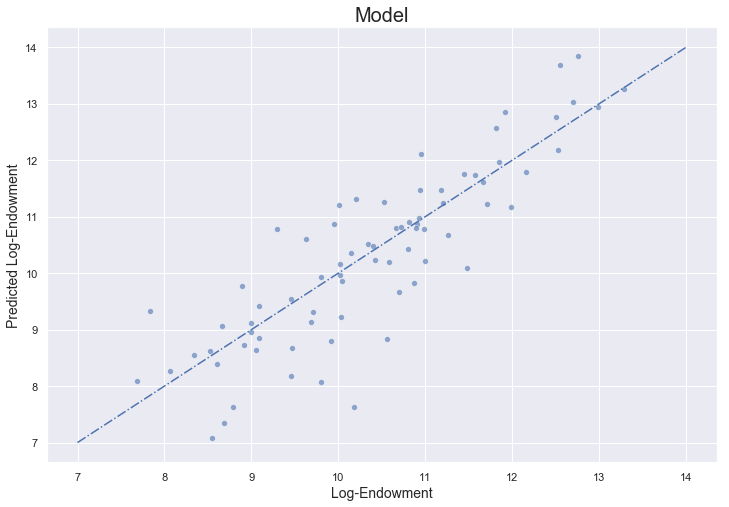

In [336]:
sns.set()
plt.figure(figsize=(12,8))
modelplot = sns.scatterplot(best_elastic.predict(X_te), y_test, alpha = .6);
plt.plot(np.linspace(7,14),np.linspace(7,14), linestyle = "-.");
plt.title('Model', fontsize=20)
plt.xlabel('Log-Endowment', fontsize=14)
plt.ylabel('Predicted Log-Endowment', fontsize=14)

modelplot.get_figure().savefig("modelplot.png", format='png', dpi=1000 ,bbox_inches='tight')

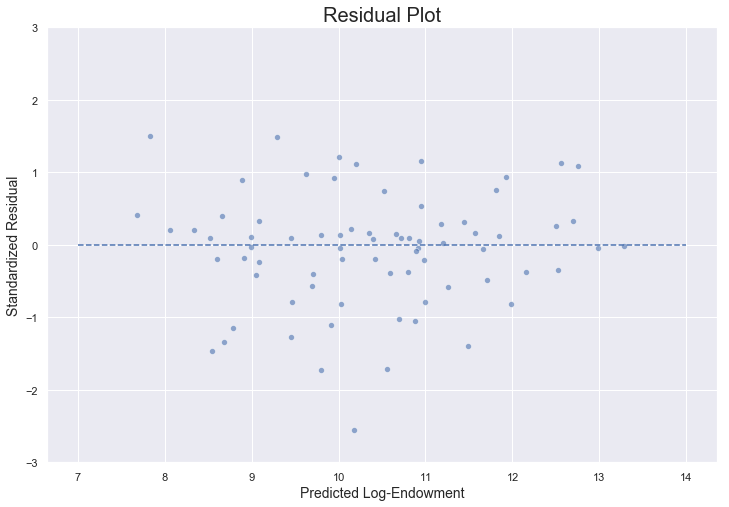

In [337]:
plt.figure(figsize=(12,8))
resplot = sns.scatterplot(best_elastic.predict(X_te), y_test - best_elastic.predict(X_te), alpha=.6)
resplot.set_ylim(bottom=-3,top=3)
plt.plot(np.linspace(7,14),np.linspace(0,0), linestyle = "--")
plt.title('Residual Plot', fontsize=20)
plt.xlabel('Predicted Log-Endowment', fontsize=14)
plt.ylabel('Standardized Residual', fontsize=14)

resplot.get_figure().savefig("resplot.png", format='png', dpi=1000 ,bbox_inches='tight')

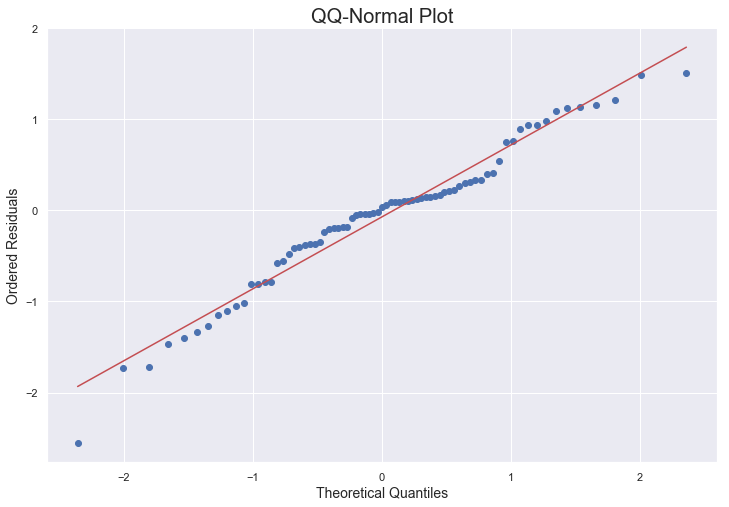

In [355]:
import pylab 
import scipy.stats as stats

plt.figure(figsize=(12,8));
qqplot = stats.probplot(y_test - best_elastic.predict(X_te), dist="norm", plot=pylab);
plt.title('QQ-Normal Plot', fontsize=20)
plt.xlabel('Theoretical Quantiles', fontsize=14)
plt.ylabel('Ordered Residuals', fontsize=14)
plt.savefig("qqplot.png", format='png', dpi=1000 ,bbox_inches='tight')